# "Uncorrelation" demo
From Soch, J., Allefeld, C., & Haynes, J. D. (2020). Inverse Transformed Encoding Models–a solution to the problem of correlated trial-by-trial parameter estimates in fMRI decoding. Neuroimage, 209, 116449.

In [1]:
import numpy as np
from scipy.linalg import toeplitz, sqrtm
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

Let's specify a two-stage data simulation scenario. We assume that a set of $P$ trials across $N$ time points &mdash; summarized in a "design matrix" $X_{1}$ &mdash; "activate" a voxel according to weights $\beta$, plus some additive noise $\epsilon$, resulting in a particular $N \times 1$ time series $y$:

\begin{align}
y = X_{1}\beta + \epsilon
\end{align}

Importantly, there might be some inherent trial-by-trial correlation between the $P$ variables, which is common in single-trial fMRI analyses (as we assume here), which we summarize in a $P \times P$ covariance matrix $U$, generated through an AR1 process with a particular base correlation $\rho$.

Now, we also assume that the "activations", $\beta$, are in turn generated by a set of $Q$ properties of, e.g., our stimulus set &mdash; summarized in a "design matrix" $X_{2}$ &mdash; weighted by a set of parameters $\phi$:

\begin{align}
\beta = X_{2}\phi
\end{align}

In [2]:
N = 600
P = 120
Q = 5
ρ = 0.5
U = ρ ** toeplitz(np.arange(P))
σ2 = 2

X1 = np.random.multivariate_normal(np.zeros(P), U, size=N)
X2 = np.random.normal(0, 1, size=(P, Q))
ϕ = np.random.normal(0, 0.1, size=Q)
β = X2 @ ϕ

We can run a "first-level" model to estimate the "activation" parameters $\hat{\beta}$ (assuming uncorrelated errors, $\epsilon$):

\begin{align}
\hat{\beta} = (X_{1}^{T}X_{1})^{-1}X_{1}^{T}y
\end{align}

To estimate the set of parameters $\hat{\phi}$, we can run a "second-level" model in which we, for now, assume uncorrelated errors:

\begin{align}
\hat{\phi} = (X_{2}^{T}X_{2})^{-1}X_{2}^{T}\hat{\beta}
\end{align}

However, as is shown in the Soch et al. paper, it's more efficient to incorporate knowledge about the trial-by-trial covariance ($U$) as induced by the first-level design matrix $X_{1}$ using generalized least squares:

\begin{align}
\hat{\phi} = (X_{2}^{T}U^{-1}X_{2})^{-1}X_{2}^{T}U^{-1}\hat{\beta}
\end{align}

where, in practice, $U$ needs to be estimated from the design matrix:

\begin{align}
U = (X_{1}^{T}X_{1})^{-1}
\end{align}

Alternatively, it is possible to "prewhiten" the second-level design matrix ($X_{2}$) and the second-level data ($\hat{\beta}$):

\begin{align}
\hat{\beta}^{*} = U^{-\frac{1}{2}}\hat{\beta} = (X_{1}^{T}X_{1})^{\frac{1}{2}}\hat{\beta} \\
X_{2}^{*} = U^{-\frac{1}{2}}X_{2} = (X_{1}^{T}X_{1})^{\frac{1}{2}}X_{2}
\end{align}

which outputs can subsequently be used in an ordinary OLS model (which is equivalent to running GLS as outlined above):

\begin{align}
\hat{\phi} = (X_{2}^{*T}X_{2}^{*})^{-1}X_{2}^{*}\hat{\beta}
\end{align}

Below, we simulate our data ($y$) iteratively and estimate the second-level parameters $\hat{\phi}$ with and without consideration of the first-level trial-by-trial covariance ($U$), showing that the former leads to a more efficient estimation of the second-level parameters and to a better fit in general:

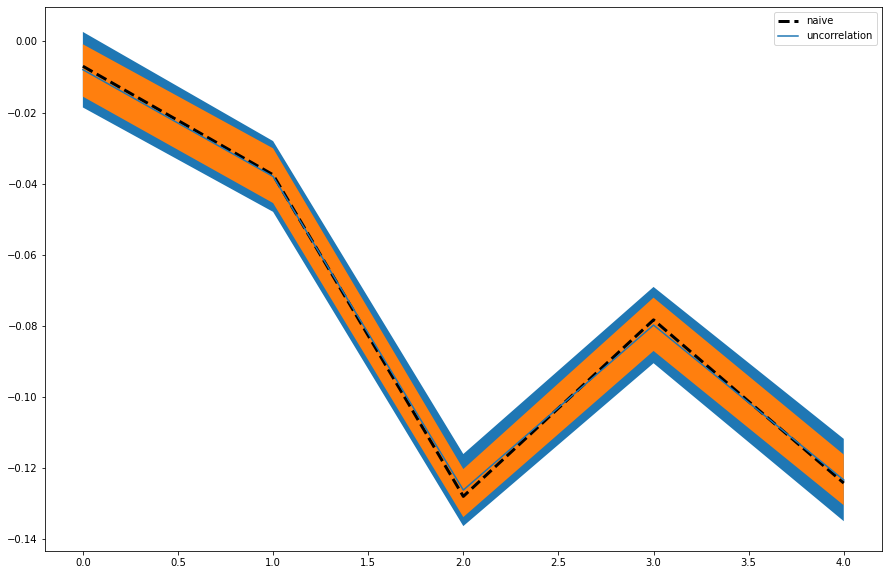

In [12]:
model = LinearRegression()
iters = 100

ϕ_naive = np.zeros((iters, Q))
ϕ_uncor = np.zeros((iters, Q))
r2_naive = np.zeros(iters)
r2_uncor = np.zeros(iters)
for i in range(iters):
    ϵ = np.random.normal(0, σ2, size=N)
    y = X1 @ β + ϵ

    βh = np.linalg.lstsq(X1, y, rcond=None)[0]
    ϕ_naive[i, :] = np.linalg.lstsq(X2, βh, rcond=None)[0]
    r2_naive[i] = cross_val_score(model, X2, βh, cv=6).mean()
    
    U_inv = X1.T @ X1
    U_sqrt = sqrtm(U_inv)
    βh_pw = U_sqrt @ βh
    X2_pw = U_sqrt @ X2
    ϕ_uncor[i, :] = np.linalg.inv(X2_pw.T @ X2_pw) @ X2_pw.T @ βh_pw
    # Line below: GLS formulation of uncorrelation (mathematically the same as line above)
    #ϕ_uncor[i, :] = np.linalg.inv(X2.T @ U_inv @ X2) @ X2.T @ U_inv @ βh
    
    r2_uncor[i] = cross_val_score(model, X2_pw, βh_pw, cv=6).mean()
    
plt.figure(figsize=(15, 10))
plt.plot(ϕ, c='k', ls='--', lw=3)
plt.plot(ϕ_naive.mean(axis=0))
plt.fill_between(np.arange(Q),
                 ϕ_naive.mean(axis=0) + ϕ_naive.std(axis=0),
                 ϕ_naive.mean(axis=0) - ϕ_naive.std(axis=0))
plt.fill_between(np.arange(Q),
                 ϕ_uncor.mean(axis=0) + ϕ_uncor.std(axis=0),
                 ϕ_uncor.mean(axis=0) - ϕ_uncor.std(axis=0))
plt.legend(['naive', 'uncorrelation'])

And plot second-level model fit ($R^{2}$):

Text(0, 0.5, 'Freq')

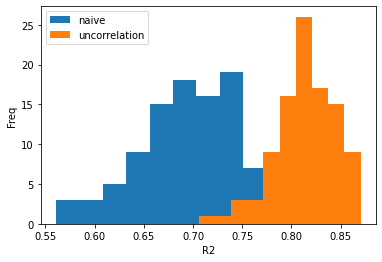

In [11]:
plt.hist(r2_naive)
plt.hist(r2_uncor)
plt.legend(['naive', 'uncorrelation'])
plt.xlabel('R2')
plt.ylabel('Freq')